<a href="https://colab.research.google.com/github/anilalperr/AitDeepLearning/blob/main/Copy_of_AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from seaborn import countplot
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import sys
import re, cgi
import seaborn as sns

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [59]:
text1_url = "https://www.gutenberg.org/files/2701/2701-0.txt" # Moby Dick by Herman Melville 
urlretrieve(text1_url, 'book.txt')
text_hermann = open("book.txt", encoding='utf-8').read().lower()

text2_url = "https://www.gutenberg.org/cache/epub/64317/pg64317.txt" # The Great Gatsby by F. Scott Fitzgerald
urlretrieve(text2_url, 'book2.txt')
text_scott = open("book2.txt", encoding='utf-8').read().lower()

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

Number of characters in Moby Dick: 1238355
Number of characters in the Great Gatsby: 289901


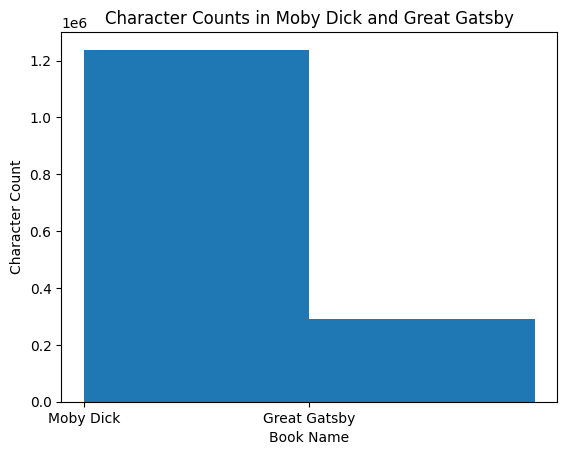

In [60]:
print('Number of characters in Moby Dick:', len(text_hermann))
print('Number of characters in the Great Gatsby:', len(text_scott))

counts = [len(text_hermann), len(text_scott)]

# Define the bin edges
bin_edges = [0, 1, 2]

# Create the histogram using the count values and bin edges
plt.hist(["Moby Dick", "Great Gatsby"], bins=bin_edges, weights=counts)

# Set the x-axis labels and title
plt.xlabel('Book Name')
plt.ylabel('Character Count')
plt.title('Character Counts in Moby Dick and Great Gatsby')

# Show the histogram
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [61]:
chars = sorted(list(set(text_hermann+text_scott)))
print("Unique characters of the books:", len(chars))
print(chars)

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print("Indices to char dictionary:", indices_char)

Unique characters of the books: 83
['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£', 'â', 'æ', 'ç', 'è', 'é', 'ê', 'ô', 'œ', 'η', 'ο', 'ς', 'τ', 'ϰ', 'ו', 'ח', '\u200a', '—', '‘', '’', '“', '”', '…', '\ufeff']
Indices to char dictionary: {0: '\t', 1: '\n', 2: ' ', 3: '!', 4: '"', 5: '#', 6: '$', 7: '%', 8: '&', 9: "'", 10: '(', 11: ')', 12: '*', 13: ',', 14: '-', 15: '.', 16: '/', 17: '0', 18: '1', 19: '2', 20: '3', 21: '4', 22: '5', 23: '6', 24: '7', 25: '8', 26: '9', 27: ':', 28: ';', 29: '?', 30: '[', 31: ']', 32: '_', 33: 'a', 34: 'b', 35: 'c', 36: 'd', 37: 'e', 38: 'f', 39: 'g', 40: 'h', 41: 'i', 42: 'j', 43: 'k', 44: 'l', 45: 'm', 46: 'n', 47: 'o', 48: 'p', 49: 'q', 50: 'r', 51: 's', 52: 't', 53: 'u', 54: 'v', 55: 'w', 56: 'x', 57:

In [62]:
maxlen  = 60
step    = 100   # the step size between two "sentence" is 30 characters
sentences_hermann  = [] # split the texts in Moby Dick
sentences_scott = [] # split the texts in the Great Gatsby

for i in range(0, len(text_hermann)-maxlen, step):
    sentences_hermann.append(text_hermann[i:i+maxlen])

for i in range(0, len(text_scott)-maxlen, step):
    sentences_scott.append(text_scott[i:i+maxlen])

sentences = sentences_hermann + sentences_scott

print('Number of training samples:', len(sentences))

Number of training samples: 15282


In [63]:
X = np.zeros((len(sentences), maxlen, len(chars)))
y = np.zeros((len(sentences),1))

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence): 
        X[i,t,char_indices[char]] = 1
    if i < len(sentences_hermann):
      y[i] = 0
    else:
      y[i] = 1

print("Shape of the input data:", X.shape)
print("Shape of the target data:", y.shape)

Shape of the input data: (15282, 60, 83)
Shape of the target data: (15282, 1)


## Data splitting
Split the data into train, validate and test sets. Make 

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [65]:
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[-2], X.shape[-1]))) # (batch, 128)
model.add(Dense(1, activation='sigmoid'))

In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               108544    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 108,673
Trainable params: 108,673
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Model training
Train the model and apply early stopping.

In [68]:
es = EarlyStopping(patience=5)

In [69]:
network_history = model.fit(X_train, y_train, 
                            validation_data=(X_val,y_val),
                            batch_size=128,                             
                            epochs=1000, 
                            verbose=1, 
                            callbacks=[es])

Epoch 1/1000
59/59 [==============================] - 17s 248ms/step - loss: 0.5150 - accuracy: 0.7972 - val_loss: 0.4883 - val_accuracy: 0.8050
Epoch 2/1000
59/59 [==============================] - 13s 225ms/step - loss: 0.4805 - accuracy: 0.8071 - val_loss: 0.4768 - val_accuracy: 0.8069
Epoch 3/1000
59/59 [==============================] - 14s 239ms/step - loss: 0.4347 - accuracy: 0.8246 - val_loss: 0.4437 - val_accuracy: 0.8305
Epoch 4/1000
59/59 [==============================] - 14s 239ms/step - loss: 0.4040 - accuracy: 0.8362 - val_loss: 0.4072 - val_accuracy: 0.8358
Epoch 5/1000
59/59 [==============================] - 14s 241ms/step - loss: 0.3994 - accuracy: 0.8375 - val_loss: 0.4126 - val_accuracy: 0.8333
Epoch 6/1000
59/59 [==============================] - 14s 241ms/step - loss: 0.3912 - accuracy: 0.8412 - val_loss: 0.4146 - val_accuracy: 0.8321
Epoch 7/1000
59/59 [==============================] - 13s 226ms/step - loss: 0.3887 - accuracy: 0.8413 - val_loss: 0.3904 - val_ac

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [70]:
print(model.evaluate(X_test, y_test))

144/144 [==============================] - 6s 42ms/step - loss: 0.3723 - accuracy: 0.8552
[0.3723456561565399, 0.8551799058914185]


## Confusion matrix
Calculate and display the confusion matrix.

In [74]:
preds = model.predict(X_test)
preds = np.round(preds)

144/144 [==============================] - 6s 41ms/step


In [75]:
tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel()
print({"tn": tn, "fp": fp, "fn": fn, "tp":tp})

{'tn': 3602, 'fp': 158, 'fn': 506, 'tp': 319}
